In [1]:
import os

import SimpleITK as sitk

import pkutils as pkutils

import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import r2_score, roc_auc_score

import pandas as pd

import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import roc_curve, auc



In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
time_arr = np.load("timeArray.npy", allow_pickle=True).item()

stat_df = pd.read_csv("stat_df.csv")

stat_df.head()

,pid,ref_id,age,sex,weight,height,contrast_agent,slice_thickness,voxel_spacing,img_matrix,...,TE,FA,FOV,num_of_phases,acquisition_period,manufacturer,version,field_strength,pdl1>=1%,pdl1>=50%
0,2021064,paz40,067Y,F,49,1.69,DOTAREM,3,"[3.12, 3.12, 3.0]","[128, 128, 32]",...,0.74,25,"[400.0, 400.0, 96.0]",30,1.47,SIEMENS,syngo MR E11,1.5,1,1
1,2565228,paz9,060Y,M,88,1.80,DOTAREM,3,"[3.12, 3.12, 3.0]","[128, 128, 36]",...,0.73,25,"[400.0, 400.0, 108.0]",30,1.54,SIEMENS,syngo MR E11,1.5,0,0
2,2780061,paz3,056Y,M,84,1.75,DOTAREM,3,"[3.12, 3.12, 3.0]","[128, 128, 32]",...,0.74,25,"[400.0, 400.0, 96.0]",30,1.47,SIEMENS,syngo MR E11,1.5,0,0
3,2737310,paz35,070Y,M,82,1.75,DOTAREM,3,"[3.12, 3.12, 3.0]","[128, 128, 36]",...,0.73,25,"[400.0, 400.0, 108.0]",30,1.54,SIEMENS,syngo MR E11,1.5,1,0
4,2776694,paz24,067Y,M,65,1.00,DOTAREM,3,"[3.0, 3.0, 3.0]","[128, 128, 32]",...,0.74,25,"[384.0, 384.0, 96.0]",30,1.47,SIEMENS,syngo MR E11,1.5,0,0


In [4]:
sample_ids = stat_df.ref_id.to_list()

##### Voxel-wise Feature Extraction - Median, Std, 90th Percentile

In [5]:
DCE_DIR = "/home/thulasiseetha/research/dataset/curated/LungMR/dce"
MAP_DIR = "pk_maps"

In [6]:
class Percentile(object):
    
    def __init__(self, p):
        
        self.p = p
        
    def __call__(self, arr):
        
        return np.percentile(arr, self.p)

In [7]:
feat_methods = {"median":np.median, "90percentile":Percentile(90), "std":np.std}

In [8]:
voxel_pk_df = {"sample_id":[], "pk_map":[],  "median":[], "90percentile":[], "std":[], "pdl1>=1%":[], "pdl1>=50%":[]}

for sample_id in tqdm(sample_ids, position=0, desc="extracting features"):
    
    row_dict = stat_df[stat_df.ref_id==sample_id].iloc[0].to_dict()
    tps_50 = int(row_dict["pdl1>=50%"])
    tps_1 = int(row_dict["pdl1>=1%"])
    
    mask_img = sitk.ReadImage(os.path.join(DCE_DIR, "masks", sample_id, "mask.nii.gz"))
    mask_arr = sitk.GetArrayFromImage(mask_img)
    
    r2_img = sitk.ReadImage(os.path.join(MAP_DIR, sample_id, "r2.nii.gz"))
    r2_arr = sitk.GetArrayFromImage(r2_img)

    for pk_map in ["t0", "kep", "ktrans", "ve", "vp", "r2"]:

        voxel_pk_df["sample_id"].append(sample_id)
        voxel_pk_df["pk_map"].append(pk_map)

        map_img = sitk.ReadImage(os.path.join(MAP_DIR, sample_id, f"{pk_map}.nii.gz"))
        map_arr = sitk.GetArrayFromImage(map_img)

        voxel_arr = map_arr[(mask_arr==1)&(r2_arr>0)] #r2_arr>0 is to exclude necrotic voxels
        for feat,feat_fn in feat_methods.items():
            voxel_pk_df[feat].append(feat_fn(voxel_arr))
            
        voxel_pk_df["pdl1>=1%"].append(tps_1)
        voxel_pk_df["pdl1>=50%"].append(tps_50)

voxel_pk_df = pd.DataFrame(voxel_pk_df)

extracting features: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:05<00:00,  6.67it/s]


##### Visualization

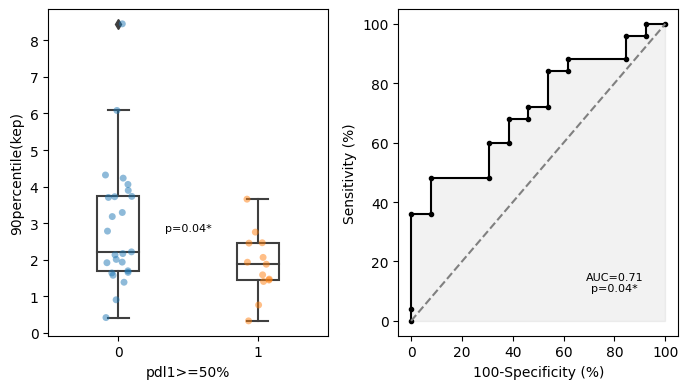

In [9]:
# plt.figure(figsize=(3,4))

pk_map="kep"
feat="90percentile"
label_column = "pdl1>=50%"

_df = voxel_pk_df[voxel_pk_df.pk_map==pk_map]

x1 = _df[(_df[label_column]==0)][feat].to_list()
x2 = _df[(_df[label_column]==1)][feat].to_list()

u, p_value = stats.mannwhitneyu(x1, x2)
        
        
fig, ax = plt.subplots(1, 2, figsize=(7, 4))

sns.boxplot(data=_df, x=label_column, y=feat, hue=label_column, width=0.3, boxprops={'facecolor':'None'}, dodge=False, ax=ax[0])
ax[0].text(0.5,3.0,f'p={p_value:.2f}*', fontsize=8, ha='center', va='top')
# Overlay points using sns.stripplot
sns.stripplot(
    data=_df,
    x=label_column,
    y=feat,
    hue=label_column,
    jitter=True,  # Add jitter for better visualization
    marker='o',  # Marker style for the points
    alpha=0.5,  # Adjust transparency
    ax=ax[0]
)



ax[0].set_ylabel(f'{feat}({pk_map})')
ax[0].set_xlabel(label_column)

ax[0].legend().remove()

y_true = _df[label_column]
y_scores = _df[feat]

fpr, tpr, thresholds = roc_curve(1-y_true, y_scores)

ideal_index = np.argmax(tpr-fpr)
ideal_threshold = thresholds[ideal_index]
ideal_fpr = fpr[ideal_index]
ideal_tpr = tpr[ideal_index]

specificity = (1-ideal_fpr)
sensitivity = ideal_tpr

roc_auc = auc(fpr, tpr)

ax[1].plot(fpr * 100, tpr * 100, marker='o', color='black', markersize=3)
ax[1].fill_between(fpr * 100, tpr * 100, alpha=0.1, color='gray')
ax[1].plot([0, 100], [0, 100], linestyle='--', color='gray')
ax[1].set_ylabel("Sensitivity (%)")
ax[1].set_xlabel("100-Specificity (%)")
ax[1].text(80, 10, f'AUC={roc_auc:.2f}\np={p_value:.2f}*', fontsize=8, ha='center')

plt.tight_layout()

# plt.savefig('sample.png')
# ax[1].plot(ideal_fpr * 100, ideal_tpr * 100, 'ro')  # Red marker for the ideal cutoff
# ax[1].annotate(
#     f' Ideal Cutoff\nThreshold: {ideal_threshold:.2f}\nSensitivity: {sensitivity:.2f}\nSpecificity: {specificity:.2f}',
#     xy=(ideal_fpr * 100, ideal_tpr * 100),
#     xytext=(ideal_fpr * 100 + 5, ideal_tpr * 100 - 10),
#     arrowprops=dict(facecolor='red', shrink=0.05),
#     fontsize=9,
#     color='red'
# )



